# Message passing for variational inference in causal graphs

Say you have a causal graph, and you want to perform variational Bayesian inference on it. You can do this the usual way, minimizing the free energy directly with a lot of maths tailored specifically for your model + maybe gradient descent. Or you can use _message passing_. So I am writing this post in an attempt to learn message passing.

The material discussed in this post all comes from [this](http://www.jmlr.org/papers/volume6/winn05a/winn05a.pdf). Some general remarks: 
- VPM applies when the nodes correspond to conditional distributions in the exponential family.
- In VMP, the messages are exponential family distributions 
- summarised either by their natural parameter vector (for child-to-parent messages) or by a vector of moments (for parent-to-child messages). 
- These messages are defined so that the optimal variational distribution for a node can be found by summing the messages from its children together with a function of the messages from its parents, where this function depends on the conditional distribution for the node.

## Review of variational inference

The important equation is:

$$
\ln(P(\textbf{V})) = \mathcal{L}(Q) + KL( Q || P )
$$

where:
- $\mathbf{V}$ is the set of observable variables in the graph
- $\mathbf{H}$ is the set of hidden variables.
- $P( \mathbf{H} | \mathbf{V} )$ is the true posterior distribution, which we don't know.
- $P( \mathbf{V} )$ is the marginal likelihood, which we cannot calculate directly.
- $Q( \mathbf{H} )$ is the approximate distribution which we are trying to make as close as possible to the posterior $P( \mathbf{H} | \mathbf{V} )$.
- $KL( Q || P ) $ is the Kullbach-Leibler divergence from $Q$ to $P$.

So the main thing about this equation is that the $KL$ is always non-negative and $\ln \left(P(\textbf{V})\right)$ is fixed. Therefore, to minimize the $KL$, we should maximise the lower-bound $\mathcal{L}$:

$$
\mathcal{L}(Q) = \sum_\mathbf{H} Q(\mathbf{H}) \ln \left( \frac{P( \mathbf{H}, \mathbf{V} )}{Q(\mathbf{H})} \right)
$$

or, equivalently, minimize the free energy.

If this is all to be helpful, $Q$ has to be simpler than $P$. One way to simplify $P$ is to assume that disjoint groups of variables are independent, so that we write $Q$ as:

$$
\prod_i Q_i(\mathbf{H}_i)
$$

where $\mathbf{H}_i$ is a group of variables for each $i$. This corresponds to the assumptions that the different groups of variables are mutually independent - our estimation of the value of a variable in one of the groups does not depend on the value of any of the variables in any of the other groups.

Under this assumption, the negative free energy $\mathcal{L}$ takes a more specific form:

\begin{align}
\mathcal{L}(Q) 
& = \sum_\mathbf{H} \prod_i \left( Q_i(\mathbf{H}_i) \right) \ln \left( \frac{P( \mathbf{H}, \mathbf{V} )}{\prod_i \left( Q_i(\mathbf{H}_i) \right)} \right) \\
& = 
\sum_\mathbf{H} \left( \prod_i \left( Q_i(\mathbf{H}_i) \right) \ln \left( P( \mathbf{H}, \mathbf{V} ) \right) \right) - 
\sum_\mathbf{H} \left( \prod_i \left( Q_i(\mathbf{H}_i) \right) \ln \left( \prod_i \left( Q_i(\mathbf{H}_i) \right) \right) \right) \\
& = 
\sum_\mathbf{H} \left( \prod_i \left( Q_i(\mathbf{H}_i) \right) \ln \left( P( \mathbf{H}, \mathbf{V} ) \right) \right) - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
\end{align}

Next, just consider the left summand. Take one factor $j$ out of $\mathbf{H}$ and separate out all the terms in $j$ in the left part of the equation. We can do this because the possible values of $\mathbf{H}$ is the cartesian product of the values of the variables in $\mathbf{H}$, and so we can express it as nexted sums across its component dimensions:

$$
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \sum_\mathbf{H_{-j}} \left( \prod_{-j} \left( Q_{-j}(\mathbf{H}_{-j}) \right) \ln \left( P( \mathbf{H}= \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right) \right) - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
$$

The internal part of the left summand can then be expressed as an expectation of $\mathbf{H}_{-j}$:

$$
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \mathbb{E}_{\mathbf{H}_{-j}} \left[
\ln \left( P( \mathbf{H} = \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right) \right] - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
$$

Then we log and exponentiate an internal expression, and the above becomes:

$$
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{\mathbf{Z}}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[\ln \left( P( \mathbf{H} = \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right) \right] } \right) - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
$$

and finally, multiply and divide by $\mathbf{Z}$ picking a $\left( \mathbf{Z} \right)$ that normalizes $e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ \ln \left( P( H= \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right) \right] }$, and move the nominator out:

$$
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ \ln \left( P( \mathbf{H} = \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right) \right] } \right) - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
$$

Call $E(\mathbf{H}, \mathbf{V}) = \ln \left( P(  \mathbf{H} = \{ \mathbf{H_j}, \mathbf{H_{-j}} \}, \mathbf{V} ) \right)$ and rewrite as:

$$
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_i \sum_\mathbf{H} \left( \prod_k \left( Q_k(\mathbf{H}_k) \right) \ln \left( Q_i(\mathbf{H}_i) \right) \right)
$$

To deal with the right part, note that the following can be rewritten:

$$
\prod_k \left( Q_k(\mathbf{H}_k) \right) = Q_i(\mathbf{H}_i) Q_{-i}(\mathbf{H}_{-i})
$$

where 

$$
Q_i(\mathbf{H}_{-i}) = \prod_{k \neq i} \left( Q_k(\mathbf{H}_k) \right)
$$

So we can rewrite the above as follows:

$$
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_i \sum_\mathbf{H} Q_i(\mathbf{H}_i) Q_{-i}(\mathbf{H}_{-i}) \ln \left( Q_i(\mathbf{H}_i) \right)
$$

and we can decompose $\mathbf{H}$ as we have done above already, getting:

$$
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_i  \sum_\mathbf{H_i} \sum_\mathbf{H_{-i}} Q_{-i}(\mathbf{H}_{-i}) Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right)
$$

So the internal part of the right summand becomes an expectation under $Q_{-i}(\mathbf{H}_{-i})$

$$
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_i  \sum_\mathbf{H_i} \mathbb{E}_{Q_{-i}(\mathbf{H}_{-i})} \left[ Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right) \right] = \\
\ln\left( \mathbf{Z} \right) + \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_i  \sum_\mathbf{H_i} Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right)
$$

Recall that the sum of $i$s is the sum over the groups of variables. So we can separate out the $j$th one on the right summand, getting:

$$
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] } \right) - 
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( Q_j(\mathbf{H}_j) \right) - 
\sum_{i \neq j}  \sum_\mathbf{H_i} Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right) + \ln\left( \mathbf{Z} \right)
$$

We can bring together the two expectations under $j$:

$$
\sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{\frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] }}{Q_j(\mathbf{H}_j) } \right) - 
\sum_{i \neq j}  \sum_\mathbf{H_i} Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right) + \ln\left( \mathbf{Z} \right) 
$$

Now the choice of $\mathbf{Z}$ makes sense, because that makes the fraction on the left hand side a fraction of two distributions, and therefore the whole expression a negative KL divergence!:

$$
- \sum_\mathbf{H_j} Q_j(\mathbf{H}_j) \ln \left( \frac{Q_j(\mathbf{H}_j) }{\frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] }} \right) - 
\sum_{i \neq j}  \sum_\mathbf{H_i} Q_i(\mathbf{H}_i) \ln \left( Q_i(\mathbf{H}_i) \right) + \ln\left( \mathbf{Z} \right) = \\
- KL\left[ Q_j || Q_{-j}^* \right] + \text{ stuff that is independent of } Q_j
$$

where:

$$
Q_{-j}^*(\mathbf{H}_{-j}) = \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] }
$$

Note that this was really useful, because the aim was to mazimise the expression, which represented the lower bound $\mathcal{L}$. And we can maximise the expression with respect to node $j$ by minimizing $KL\left[ Q_j || Q_{-j}^* \right]$. Now, the KL divergence is minimized (and in fact equal to 0) when the two involved distributions are identical, so all we need to do is solve the following expression where we assume that the two are identical:

$$
Q_j(\mathbf{H}_{j}) = Q_{-j}^*(\mathbf{H}_{-j}) = \frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] }
$$

## Variational message passing

The idea of message passing is to initialize the distribution for all nodes, and then loop through them repeatedly, updating them according to the equation above until we get some kind of convergence and the equality becomes true for all nodes.

In order to understand how the equation above is used reduce the overall maximization of the lower bound to local operations on single nodes, the concept of _Markov blankets_ will be needed. I'm not gonna explain the intuition here, I'll just assume it. I'll just remind you that in a causal graph (which a directed graph), the Markov blanket for a node $X$ consists of the parents of $X$, $pa(X)$, the children of $X$, $ch(X)$, and all the other parents of the children of $X$ (the co-parents of $X$), $copa(X)$.

This is important because it allows us to simplify $Q_{-j}^*$, and more specifically the expectation:

$$
\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right]
$$

Since the value of $Q_j$ which we are interested in can only depend on its Markov blanket, we can rewrite the following:

$$
\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] = \\
\mathbb{E}_{ mb(j) } \left[ E(\mathbf{H} = \left\{ \mathbf{H}_j, mb \left( j \right) \right\}, \mathbf{V}) \right]
$$

Recalling the definition of $E$ above, we can rewrite this as:

$$
\mathbb{E}_{ mb(j) } \left[ \ln \left( P( H= \{ \mathbf{H_j}, mb(j) \}, \mathbf{V} ) \right) \right] = \\
\mathbb{E}_{ mb(j) } \left[ \ln \left( P(pa(j)) \, P( H_j | pa(j) ) \, P(copa(x)) \, P(ch(j) | copa(j), H_j) \right) \right] = \\
\mathbb{E}_{ mb(j) } \left[ \ln \left( P(pa(j)) \right) + \ln \left( P( H_j | pa(j) ) \right) + \ln \left( P(copa(x)) \right) + \ln \left( P(ch(j) | copa(j), H_j) \right) \right] = \\
\mathbb{E}_{ mb(j) } \left[ \ln \left( P(pa(j)) \right) \right] + \mathbb{E}_{ mb(j) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \mathbb{E}_{ mb(j) } \left[ \ln \left( P(copa(x)) \right) \right] + \mathbb{E}_{ mb(j) } \left[ \ln \left( P(ch(j) | copa(j), H_j) \right) \right] = 
$$

If you're wondering what happened to $\mathbf{V}$, this form implicitly accounts for it because it will be included among the children of some of the nodes. Moreover, we can ignore all terms that do not depend on $H_j$, because they are constant wrt the expectation:

$$
\mathbb{E}_{ mb(j) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \mathbb{E}_{ mb(j) } \left[ \ln \left( P(ch(j) | copa(j), H_j) \right) \right] + \text{constant} = \\
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \mathbb{E}_{ Q(copa(j), ch(j)) } \left[ \ln \left( P(ch(j) | copa(j), H_j) \right) \right] + \text{constant} = \\
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \mathbb{E}_{ Q(copa(j), ch(j)) } \left[ \ln \left( \prod_{i \in ch(j)} P( i | pa(i)) \right) \right] + \text{constant} = \\
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \mathbb{E}_{ Q(copa(j), ch(j)) } \left[ \sum_{i \in ch(j)} \ln \left( P( i | pa(i)) \right) \right] + \text{constant} = \\
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right] + \sum_{i \in ch(j)} \mathbb{E}_{ Q(copa(j), ch(j)) } \left[ \ln \left( P( i | pa(i)) \right) \right] + \text{constant}
$$

This is great, because now to update the distribution of node $j$ we can use independent messages from $j$'s parents and $j$'s children. Finding out exactly what messages to send becomes _a lot_ easier if we assume that all of the distributions are members of the exponential family of distributions, and each parent is a conjugate of its children.

## Exponential family of distributions

Let's take stock of the situation. We started with the idea of finding a posterior distribution. We have seen that we can find an approximation to it by maximizing a lower bound $\mathcal{L}$. By making the mean-field approximation, we can find the distribution for node $j$ that maximizises $\mathcal{L}$ by calculating $\frac{1}{\mathbf{Z}}e^{\mathbb{E}_{\mathbf{H}_{-j}} \left[ E(\mathbf{H}, \mathbf{V}) \right] }$. Then, it turned out that to calculate it $j$ can receive independent messages from its parents and from its children. Next, we are going to see that by assuming that the nodes in $P$ have distributions in the exponential family, things get a lot easier.

So this is a way of writing members of the exponential family of distributions (in so-called _canonical form_, where $\mathbf{\theta}$ is a vector of parameters):

$$
P(\mathbf{X} | \mathbf{\theta} ) = e^{\mathbf{\theta} \cdot \mathbf{u} (\mathbf{X}) + f(\mathbf{X}) + g(\mathbf{\theta})}
$$

where
- $\mathbf{\theta}$: the _natural parameter vector_ of the distribution. It encodes the information about the parameters.
- $\mathbf{u} (\mathbf{X})$ is the _natural statistic_ vector. It encodes a way of "synthesizing" data that expresses what the distribution needs to know about the data to determine its probability. For instance the probability of a certain vector might only depend on its mean.
- $g(\mathbf{\theta})$ is the normalization factor.

Note that if we know the natural parameter vector $\phi(\mathbf{\theta})$, we can find the expectation of the natural statistic vector. Intuitively, this means that if we know the information about the parameters that the distribution uses to calculate the probability, that's all we know to find the expectation of $\mathbf{X}$.

Consider first the first summand of the last equation from the previous section:

$$
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( P( H_j | pa(j) ) \right) \right]
$$

This is only dependent on the parents of $j$, and therefore we need to ask what message node $j$ needs to receive from its parents to find this part of the summand, which in turn we need to find $\textbf{Q}_j(\textbf{H}_j)$.

Since we assumed that the node's distribution is in the exponential family, we can rewrite this as:

\begin{align}
\mathbb{E}_{ Q(pa(j)) } \left[ \ln \left( e^{\mathbf{\theta} \cdot \mathbf{u} (\mathbf{X}) + f(\mathbf{X}) + g(\mathbf{\theta})} \right) \right] & = \mathbb{E}_{ Q(pa(j)) } \left[ \mathbf{\theta} \cdot \mathbf{u} (\mathbf{X}) + f(\mathbf{X}) + g(\mathbf{\theta}) \right]\\
& = \mathbb{E}_{ Q(pa(j)) } \left[ \mathbf{\theta} \cdot \mathbf{u} (\mathbf{X}) \right] + \mathbb{E}_{ Q(pa(j)) } \left[ f(\mathbf{X}) \right] + \mathbb{E}_{ 
Q(pa(j)) } \left[ g(\mathbf{\theta}) \right] \\
& = \mathbb{E}_{ Q(pa(j)) } \left[ \mathbf{\theta} \right] \cdot \mathbf{u}(\mathbf{X})  + f(\mathbf{X}) + \mathbb{E}_{ Q(pa(j)) } \left[ g(\mathbf{\theta}) \right] 
\end{align}

But the expected value of $\mathbf{\theta}$ is simply the expectations of the natural statistics of $j$'s parents. So that's the message that $j$ should receive from its parents.

The details of the derivation don't matter much here (you can find them online easily), but here's the conclusion:

$$
\mathbb{E}_{P(\mathbf{X} \mid \mathbf{\theta})} \left[ \mathbf{u} (\mathbf{X}) \right] = -\frac{d g(\mathbf{\theta})}{d\theta}
$$

So what does this mean? It means that we can find the expectation of the natural statistic of the parent of $j$ pretty easily, as the derivative of its normalization factor.

The second bit we are interested in is:

$$
\sum_{i \in ch(j)} \mathbb{E}_{ Q(copa(j), ch(j)) } \left[ \ln \left( P( i | pa(i)) \right) \right]
$$

Let's restrict our attention to $P( i | pa(i))$ for some specific child $i$ of $j$. Then $P( i | pa(i)$ equals $P( i | j, copa(j))$:

$$

$$

## Visualizing message passing

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [60]:
def clean_ax(ax, also_bottom=False):
    ax.patch.set_alpha(0.0)
    
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_yticks([])
    if also_bottom:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])

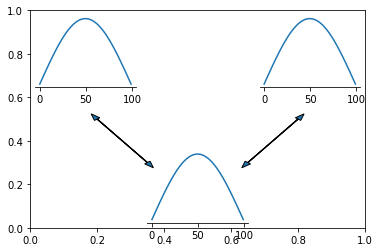

In [65]:
norm_pdf = stats.norm(0,1).pdf

top_right_dist = norm_pdf(np.linspace(-1,1,100))
top_left_dist = norm_pdf(np.linspace(-1,1,100))
bottom_dist = norm_pdf(np.linspace(-1,1,100))

fig, ax = plt.subplots()

top_right_ax = inset_axes(ax, width="30%", height=1., loc=1)
top_right_ax.plot(top_right_dist)
top_left_ax = inset_axes(ax, width="30%", height=1., loc=2)
top_left_ax.plot(top_left_dist)
bottom_ax = inset_axes(ax, width="30%", height=1., loc=8)
bottom_ax.plot(bottom_dist)

# clean_ax(ax, also_bottom=True)
clean_ax(top_right_ax)
clean_ax(top_left_ax)
clean_ax(bottom_ax)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
bottom_to_top_left_arrow = ax.arrow(0.35, 0.3, -0.15, 0.2, head_width=0.02)
bottom_to_top_right_arrow = ax.arrow(0.65, 0.3, 0.15, 0.2, head_width=0.02)
top_left_to_bottom_arrow = ax.arrow(0.2, 0.5, 0.15, -0.2, head_width=0.02)
top_right_to_bottom_arrow = ax.arrow(0.8, 0.5, -0.15, -0.2, head_width=0.02)

plt.show()